# Libraries

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import torch

from scipy.stats import pearsonr, spearmanr

from pathlib import Path

In [2]:
# Set the font family for math symbols
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
home_path = Path.home()
print(home_path)

current_dir_path = Path.cwd()
print(current_dir_path)

askap     = home_path / 'ANU' / 'ASKAP'
data_path = askap / 'data'

ml_data_path   = data_path / 'ML'
ppv_data_path  = ml_data_path / 'ppv'
seta_data_path = ml_data_path / 'seta22'

train_data_path = ml_data_path / 'train'

print(train_data_path)
print(ppv_data_path)

# Fcn

In [ ]:
def split_into_chunks(arr, chunk_size):
    return np.array([arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)])

# GPU or CPU

In [7]:
# GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


In [8]:
torch.cuda.device_count()

0

# CNN-Trans (1split)

In [ ]:
exp0_data_path = train_data_path / 'ctrans'
checkpoint_path = exp0_data_path / 'checkpoint'
pe_list  = ['original_vector',  'index_concate',  'index_add',  'sin_concate',  'sin_add', 'poly_concate', 'learnable_PEV']
pev_list = ['Original', 'Concat Index', 'Add Index', 'Concat Sinusoidal', 'Add Sinusoidal', 'Concat Polynomial', 'Learnable']
npe = len(pe_list)
prex   = 'ct_'
suffix = '_c256'

training_process_path = exp0_data_path / 'training_process' / 'c256_1split'
training_process_path = exp0_data_path / 'training_process' / 'c256_lr5'

file_list  = [training_process_path / (x + '.csv') for x in pe_list]
file_list

In [10]:
valid_mean_mse_arr = np.zeros(npe)
valid_std_mse_arr = np.zeros(npe)

test_mean_mse_arr = np.zeros(npe)
test_std_mse_arr = np.zeros(npe)

valid_mean_mse_arr_list = []
test_mean_mse_arr_list  = []

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  valid_mse_values = np.sqrt(df.valid_err.values)
  test_mse_values  = np.sqrt(df.test_err.values)

  valid_mean_mse_arr_list.append(valid_mse_values)
  test_mean_mse_arr_list.append(test_mse_values)

  valid_mean_mse = np.median(valid_mse_values)
  valid_std_mse  = valid_mse_values.std()

  test_mean_mse  = np.median(test_mse_values)
  test_std_mse   = test_mse_values.std()

  valid_mean_mse_arr[i] = valid_mean_mse
  valid_std_mse_arr[i] = valid_std_mse

  test_mean_mse_arr[i] = test_mean_mse
  test_std_mse_arr[i] = test_std_mse

In [12]:
for m,s,xi in zip(valid_mean_mse_arr, valid_std_mse_arr, pev_list):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.079554, std=0.001853  for Original
Valid MSE: Mean=0.081057, std=0.001573  for Concat Index
Valid MSE: Mean=0.078709, std=0.002885  for Add Index
Valid MSE: Mean=0.083327, std=0.002918  for Concat Sinusoidal
Valid MSE: Mean=0.079715, std=0.001735  for Add Sinusoidal
Valid MSE: Mean=0.078649, std=0.002599  for Concat Polynomial
Valid MSE: Mean=0.079674, std=0.003232  for Learnable


In [13]:
for m,s,xi in zip(test_mean_mse_arr, test_std_mse_arr, pev_list):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.079547, std=0.001893  for Original
Test MSE: Mean=0.077652, std=0.001538  for Concat Index
Test MSE: Mean=0.081610, std=0.003322  for Add Index
Test MSE: Mean=0.079137, std=0.002411  for Concat Sinusoidal
Test MSE: Mean=0.076842, std=0.001520  for Add Sinusoidal
Test MSE: Mean=0.078770, std=0.002948  for Concat Polynomial
Test MSE: Mean=0.080684, std=0.002753  for Learnable


In [ ]:
file_list1  = [training_process_path / (x + '_process' + '.csv') for x in pe_list]
file_list1

In [18]:
k = 2
pev = pev_list[k]
process_df = pd.read_csv(training_process_path / file_list1[k])
print(process_df.shape)
process_df.head()

(600, 4)


,epoch,train_err,valid_err,test_err
0,0,0.049904,0.030582,0.033241
1,1,0.034214,0.026698,0.028901
2,2,0.029799,0.021613,0.023977
3,3,0.027742,0.021686,0.024445
4,4,0.025082,0.018689,0.020931


In [19]:
process_train_err    = np.sqrt(process_df.train_err.values)
process_validate_err = np.sqrt(process_df.valid_err.values)
process_test_err     = np.sqrt(process_df.test_err.values)
epochs               = process_df.epoch.values

In [21]:
nepochs = epochs.max() + 1
nepochs

60

In [22]:
epoch_chunks = split_into_chunks(epochs, nepochs)
process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

In [25]:
rp, p_value = spearmanr(process_train_err, process_validate_err)

print(f"Pearson Correlation Coefficient: {rp}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.9525366459351274
P-value: 4.51627402015e-311


In [28]:
npe

7

In [29]:
process_train_rmse_mean = np.zeros((10, npe))
process_valid_rmse_mean = np.zeros((10, npe))
process_test_rmse_mean  = np.zeros((10, npe))

mean_train_mse_cnn = np.zeros(nepochs)
mean_valid_mse_cnn = np.zeros(nepochs)
mean_test_mse_cnn  = np.zeros(nepochs)

# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list1, pev_list)):
    process_df = pd.read_csv(training_process_path / xfile_list)

    process_train_err    = np.sqrt(process_df['train_err'].values)
    process_validate_err = np.sqrt(process_df['valid_err'].values)
    process_test_err     = np.sqrt(process_df['test_err'].values)
    epochs               = process_df['epoch'].values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
    process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
    process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

    process_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_train_err_chunks])
    process_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_validate_err_chunks])
    process_test_rmse_mean[:,i]  = np.asarray([np.median(x) for x in process_test_err_chunks])

    mean_process_train_err    = process_train_err_chunks.mean(axis=0)
    mean_process_validate_err = process_validate_err_chunks.mean(axis=0)
    mean_process_test_err     = process_test_err_chunks.mean(axis=0)

    mean_train_mse_cnn += mean_process_train_err
    mean_valid_mse_cnn += mean_process_validate_err
    mean_test_mse_cnn += mean_process_test_err
# End - for
mean_train_mse_cnn = mean_train_mse_cnn / npe
mean_valid_mse_cnn = mean_valid_mse_cnn / npe
mean_test_mse_cnn  = mean_test_mse_cnn / npe

# CNN-Trans (split)

In [33]:
exp0_data_path = train_data_path / 'ctrans'
checkpoint_path = exp0_data_path / 'checkpoint'
training_process_path = exp0_data_path / 'training_process' / 'ct256_split'

In [ ]:
pe_list  = ['original_vector',  'index_concate',  'index_add',  'sin_concate',  'sin_add', 'poly_concate', 'learnable_PEV']
pev_list = ['Original', 'Concat Index', 'Add Index', 'Concat Sinusoidal', 'Add Sinusoidal', 'Concat Polynomial', 'Learnable']
npe      = len(pe_list)
print(npe)

suffix = '_c256'

file_list  = [training_process_path / (x + '_c256.csv') for x in pe_list]
file_list

In [35]:
valid_mean_mse_arr = np.zeros(npe)
valid_std_mse_arr = np.zeros(npe)

test_mean_mse_arr = np.zeros(npe)
test_std_mse_arr = np.zeros(npe)

valid_mean_mse_arr_list = []
test_mean_mse_arr_list  = []

for (i, csvfile) in enumerate(file_list):
  df = pd.read_csv(csvfile)

  valid_mse_values = np.sqrt(df.valid_err.values)
  test_mse_values  = np.sqrt(df.test_err.values)

  valid_mean_mse_arr_list.append(valid_mse_values)
  test_mean_mse_arr_list.append(test_mse_values)

  valid_mean_mse = np.median(valid_mse_values)
  valid_std_mse  = valid_mse_values.std()

  test_mean_mse  = np.median(test_mse_values)
  test_std_mse   = test_mse_values.std()

  valid_mean_mse_arr[i] = valid_mean_mse
  valid_std_mse_arr[i] = valid_std_mse

  test_mean_mse_arr[i] = test_mean_mse
  test_std_mse_arr[i] = test_std_mse

In [37]:
for m,s,xi in zip(valid_mean_mse_arr, valid_std_mse_arr, pev_list):
  print(f"Valid MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Valid MSE: Mean=0.079123, std=0.003948  for Original
Valid MSE: Mean=0.081039, std=0.002266  for Concat Index
Valid MSE: Mean=0.081243, std=0.003041  for Add Index
Valid MSE: Mean=0.079974, std=0.002756  for Concat Sinusoidal
Valid MSE: Mean=0.082258, std=0.003552  for Add Sinusoidal
Valid MSE: Mean=0.083377, std=0.003592  for Concat Polynomial
Valid MSE: Mean=0.077956, std=0.004192  for Learnable


In [38]:
for m,s,xi in zip(test_mean_mse_arr, test_std_mse_arr, pev_list):
  print(f"Test MSE: Mean={m:.6f}, std={s:.6f}  for {xi}")

Test MSE: Mean=0.081222, std=0.002634  for Original
Test MSE: Mean=0.080295, std=0.004133  for Concat Index
Test MSE: Mean=0.081159, std=0.002884  for Add Index
Test MSE: Mean=0.078978, std=0.002956  for Concat Sinusoidal
Test MSE: Mean=0.082529, std=0.003142  for Add Sinusoidal
Test MSE: Mean=0.083178, std=0.003709  for Concat Polynomial
Test MSE: Mean=0.080291, std=0.004814  for Learnable


In [41]:
file_list  = [training_process_path / (x + '_c256_process' + '.csv') for x in pe_list]
file_list

[PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/original_vector_c256_process.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/index_concate_c256_process.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/index_add_c256_process.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/sin_concate_c256_process.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/sin_add_c256_process.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/poly_concate_c256_process.csv'),
 PosixPath('/Users/kiemhiep/ANU/ASKAP/data/ML/train/ctrans/training_process/ct256_split/learnable_PEV_c256_process.csv')]

In [42]:
k = 2
pev = pev_list[k]
process_df = pd.read_csv(training_process_path / file_list[k])
print(process_df.shape)
process_df.head()

(600, 4)


,epoch,train_err,valid_err,test_err
0,0,0.045773,0.038872,0.037137
1,1,0.032821,0.033027,0.031604
2,2,0.029236,0.210439,0.207479
3,3,0.026533,0.027505,0.025733
4,4,0.024574,0.026405,0.024695


In [43]:
process_train_err    = np.sqrt(process_df.train_err.values)
process_validate_err = np.sqrt(process_df.valid_err.values)
process_test_err     = np.sqrt(process_df.test_err.values)
epochs               = process_df.epoch.values

In [44]:
def split_into_chunks(arr, chunk_size):
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

In [45]:
nepochs = epochs.max() + 1
nepochs

60

In [46]:
epoch_chunks = split_into_chunks(epochs, nepochs)
process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

In [48]:
rp, p_value = spearmanr(process_train_err, process_validate_err)

print(f"Pearson Correlation Coefficient: {rp}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.9098962497118047
P-value: 1.107404033273198e-230


In [51]:
npe

7

In [52]:
process_train_rmse_mean = np.zeros((10, npe))
process_valid_rmse_mean = np.zeros((10, npe))
process_test_rmse_mean  = np.zeros((10, npe))

# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list, pev_list)):
    process_df = pd.read_csv(training_process_path / xfile_list)

    process_train_err    = np.sqrt(process_df.train_err.values)
    process_validate_err = np.sqrt(process_df.valid_err.values)
    process_test_err     = np.sqrt(process_df.test_err.values)
    epochs               = process_df.epoch.values

    epoch_chunks = split_into_chunks(epochs, nepochs)
    process_train_err_chunks    = split_into_chunks(process_train_err, nepochs)
    process_validate_err_chunks = split_into_chunks(process_validate_err, nepochs)
    process_test_err_chunks     = split_into_chunks(process_test_err, nepochs)

    process_train_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_train_err_chunks])
    process_valid_rmse_mean[:,i] = np.asarray([np.median(x) for x in process_validate_err_chunks])
    process_test_rmse_mean[:,i]  = np.asarray([np.median(x) for x in process_test_err_chunks])

# Training/Validation correlations (1split, split)

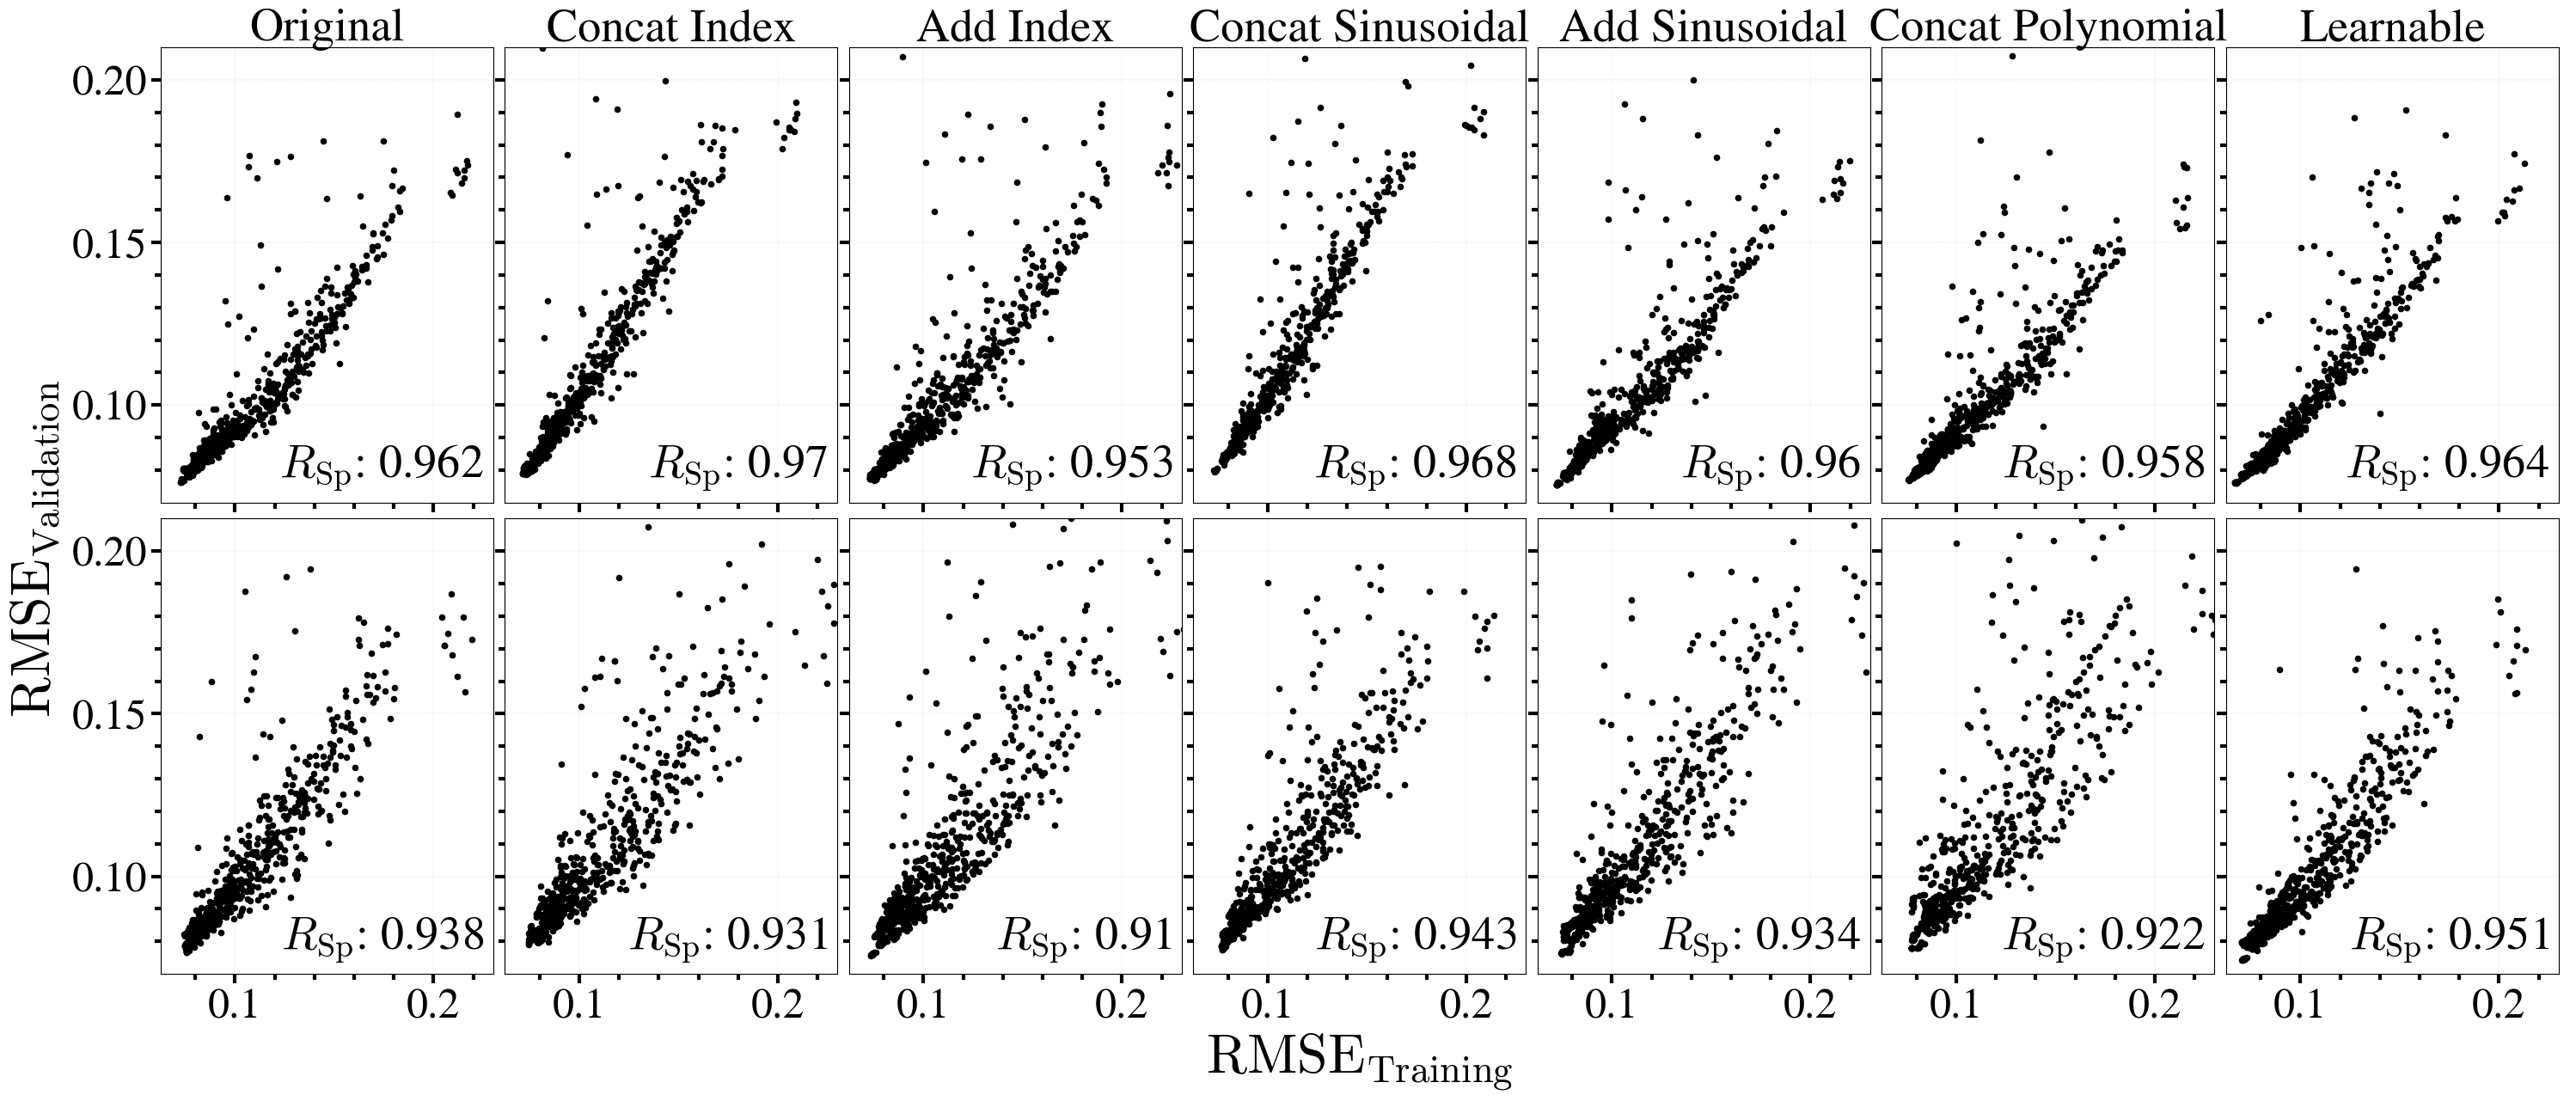

In [75]:
# Create subplots
fig, axes = plt.subplots(2, 7, figsize=(36, 14), sharey = True, sharex = True)
axes = axes.flatten()

# Loop through your scatter plot data and create subplots
for i, (xfile_list1, pev) in enumerate(zip(file_list1, pev_list)):

    # 1split
    process_df = pd.read_csv(training_process_path / xfile_list1)

    process_train_err    = np.sqrt(process_df.train_err.values)
    process_validate_err = np.sqrt(process_df.valid_err.values)
    process_test_err     = np.sqrt(process_df.test_err.values)
    epochs               = process_df.epoch.values

    rp, p_value = spearmanr(process_train_err, process_validate_err)

    ax = axes[i]
    sct1 = ax.scatter(process_train_err, process_validate_err,
                    zorder=2, s=20,
                    marker='o', vmin=0., vmax=37., c='k',
                    label='')


    

    ploti, = ax.plot([], [], 'ko', label=r'$R_\mathrm{Sp}$: ' + f'{round(rp, 3)}')
    ploti.set_visible(True)


    ax.set_title(pev, fontsize=39)
    xlabel = ''
    ylabel = r'$\mathrm{RMSE_{Validation}}$' if (i == 0)  else ''
    ax.set_ylabel(ylabel, fontsize=46, fontweight='bold')
    ax.yaxis.set_label_coords(-0.3, -0.1)

    ax.set_xlim(0.0625, 0.23)
    ax.set_ylim(0.07, 0.21)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=36, pad=4)
    ax.tick_params(axis='y', labelsize=36)
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=5)

    ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
    leg = ax.legend(loc='lower right', fancybox=False, framealpha=0., labelcolor='k', fontsize=39, handletextpad=-2.0, borderaxespad=-0.2)
    [item.set_visible(False) for item in leg.legendHandles]





# Loop through your scatter plot data and create subplots
for i, (xfile_list, pev) in enumerate(zip(file_list, pev_list)):
    # Split
    proc_df = pd.read_csv(xfile_list)

    proc_df['train_err'].fillna(proc_df['train_err'].min(), inplace=True)
    proc_df['valid_err'].fillna(proc_df['valid_err'].min(), inplace=True)
    proc_df['test_err'].fillna(proc_df['test_err'].min(), inplace=True)

    proc_train_err    = np.sqrt(proc_df.train_err.values)
    proc_validate_err = np.sqrt(proc_df.valid_err.values)
    proc_test_err     = np.sqrt(proc_df.test_err.values)
    epochs            = proc_df.epoch.values

    rp2, p_value2 = spearmanr(proc_train_err, proc_validate_err)

    ax = axes[i+7]
    sct1 = ax.scatter(proc_train_err, proc_validate_err,
                    zorder=2, s=20,
                    marker='o', vmin=0., vmax=37., c='k',
                    label='')

    ploti, = ax.plot([], [], 'ko', label=r'$R_\mathrm{Sp}$: ' + f'{round(rp2, 3)}')
    ploti.set_visible(True)

    xlabel = r'$\mathrm{RMSE_{Training}}$' if (i==3) else ''
    ylabel = r'' if (i == 0) else ''
    ax.set_ylabel(ylabel, fontsize=0, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=46, fontweight='bold')

    ax.set_xlim(0.0625, 0.23)
    ax.set_ylim(0.07, 0.21)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=36, pad=4)
    ax.tick_params(axis='y', labelsize=36)
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=5)

    ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
    leg = ax.legend(loc='lower right', fancybox=False, framealpha=0., labelcolor='k', fontsize=39, handletextpad=-2.0, borderaxespad=-0.2)
    [item.set_visible(False) for item in leg.legendHandles]
# End for

plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.035,
                    hspace=0.035
                    )


# Adjust layout
# plt.tight_layout()
plt.show()